In [1]:
pip install imbalanced-learn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip show scikit-learn

Name: scikit-learnNote: you may need to restart the kernel to use updated packages.

Version: 1.5.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

Copyright (c) 2007-2024 The scikit-learn developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior writte

In [3]:
pip show imbalanced-learn

Name: imbalanced-learn
Version: 0.12.4
Summary: Toolbox for imbalanced dataset in machine learning.
Home-page: https://github.com/scikit-learn-contrib/imbalanced-learn
Author: 
Author-email: 
License: MIT
Location: c:\Anaconda\Lib\site-packages
Requires: joblib, numpy, scikit-learn, scipy, threadpoolctl
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U scikit-learn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler

In [6]:
dtype = {
    'ResponseID': 'category',
    'UserID': 'int8',
    'Intervention': 'int8',
    'PedPed': 'int8',
    'Barrier': 'int8',
    'CrossingSignal': 'int8',
    'AttributeLevel': 'category',
    'ScenarioTypeStrict': 'category',
    'NumberOfCharacters': 'int8',
    'DiffNumberOFCharacters': 'int8',
    'Saved': 'int8',
    'Man': 'int8',
    'Woman': 'int8',
    'Pregnant': 'int8',
    'Stroller': 'int8',
    'OldMan': 'int8',
    'OldWoman': 'int8',
    'Boy': 'int8',
    'Girl': 'int8',
    'Homeless': 'int8',
    'LargeWoman': 'int8',
    'LargeMan': 'int8',
    'Criminal': 'int8',
    'MaleExecutive': 'int8',
    'FemaleExecutive': 'int8',
    'FemaleAthlete': 'int8',
    'MaleAthlete': 'int8',
    'FemaleDoctor': 'int8',
    'MaleDoctor': 'int8',
    'Dog': 'int8',
    'Cat': 'int8'
}


### 75/25

In [7]:
# Distribution of 
# 0 = 3.750.000
# 1 = 1.250.000
# to get a total dataset of 5.000.000

In [8]:
# extracting 3.750.000 rows with ResponseID = 0 from the original dataset

df_original = pd.read_csv('sub_dataset.csv', dtype=dtype)

In [9]:
df_original.shape

(5000000, 31)

In [10]:
# function make_subset

def make_subset(data, sample_size, filter_value, types):

    """ 
    Function to create a subset of the original dataset based on the ResponseID's of the original dataset.
    It will create a subset based on a value of the UserID column
    The function will return a new dataframe with the same columns as the original dataset, where the ResponseID's are kept together.

    Input:
    - Data: a string with the path to the dataset that a subset has to be taken of
    - Sample_size: the size of the subset that has to be taken
    - Filter_value: the value of the UserID column that has to be filtered on (either 1 or 0). The subset will then only be of the either LLM's or humans
    - Types: a dictionary with the column names as keys and the data types as values
    
    Output:
    - A new dataframe with the subset of the original dataset
    
    Using chunks to ensure fast processing
    """

    df_tot = pd.read_csv(data, dtype=dtype)
    sample = int(sample_size/2)

    df_tot = df_tot[df_tot['UserID'] == filter_value]                                           # getting a subset of either only LLM's or MME's (1 or 0)
    unique_ids = df_tot.drop_duplicates(subset=['ResponseID'], keep='first')                    # only keeping unique ResponseID's (not their duplicate)
    RID_list = unique_ids['ResponseID'].sample(n=sample, random_state=41).to_list()             # to a list the ResponseID's to be kept

    print(f'Expected nr of rows in output df: {len(RID_list)*2}')                               # expected size of output df


    new_df = pd.DataFrame()

    chunk_size = 500_000
    reader = pd.read_csv(data, chunksize=chunk_size, dtype=str, low_memory=False)

    for i, chunk in enumerate(reader):
    
        print(f"Processing chunk {i+1}")

        # Filter rows where ResponseID is in reader_subset
        subset_chunk = chunk[chunk['ResponseID'].isin(RID_list)]

        # Append filtered chunk to empty df
        new_df = pd.concat([new_df, subset_chunk], ignore_index=True)

        print(f"Finished processing chunk {i+1}")

    print("All chunks have been processed and combined.")

    print(new_df.shape)

    # check if each ResponseID is present twice
    print(new_df['ResponseID'].nunique() == (new_df.shape[0]/2))   # should be True

    new_df = new_df.astype(dtype=types)
    
    return new_df


# will use the resulting dataframes from this function combined to create a final dataset

In [11]:
# making subset of 3.75M of class 0
df75_sub_0 = make_subset('sub_dataset.csv', 3750000, 0, dtype)

Expected nr of rows in output df: 3750000
Processing chunk 1
Finished processing chunk 1
Processing chunk 2
Finished processing chunk 2
Processing chunk 3
Finished processing chunk 3
Processing chunk 4
Finished processing chunk 4
Processing chunk 5
Finished processing chunk 5
Processing chunk 6
Finished processing chunk 6
Processing chunk 7
Finished processing chunk 7
Processing chunk 8
Finished processing chunk 8
Processing chunk 9
Finished processing chunk 9
Processing chunk 10
Finished processing chunk 10
All chunks have been processed and combined.
(3750000, 31)
True


In [89]:
df75_sub_1 = pd.read_csv('llm_dataset.csv', dtype=dtype)

In [90]:
df75_sub_1['ScenarioTypeStrict'].value_counts()

ScenarioTypeStrict
Age              52868
Species          51230
Utilitarian      49456
Fitness          48690
Gender           47756
Social Status    43568
Name: count, dtype: int64

In [91]:
df75_sub_1.shape

(293568, 31)

In [39]:
# Use the create_total_subset function to combine the two subsets

def create_total_subset(df1, df2, types):
    """
    Function to combine two dataframes into one. Usually used to combine the subset of llm's and humans.
    Concatenates them, shuffles the rows and resets the index. Then converts the columns to the correct data types.

    Input:
    - df1: the first dataframe
    - df2: the second dataframe
    - types: a dictionary with the column names as keys and the data types as values

    Output:
    - A new dataframe with the two input dataframes combined. 
    
    """
    new_df = pd.concat([df1, df2], ignore_index=True)
    new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)
    new_df = new_df.astype(dtype=types)
    return new_df


In [40]:
# combining the two subsets
df75_before_oversampling = create_total_subset(df75_sub_0, df75_sub_1, dtype)

print(df75_before_oversampling.shape)
print(df75_before_oversampling['UserID'].value_counts())

(4043568, 31)
UserID
0    3750000
1     293568
Name: count, dtype: int64


In [41]:
# Oversampling with RandomOverSampler

In [42]:
X_75 = df75_before_oversampling.drop(['UserID', 'ResponseID'], axis=1)      # drop ResponseID as well cause no need to oversample on this + not used in the modelling anyway
y_75 = df75_before_oversampling['UserID']

In [43]:
print(X_75.shape)
print(y_75.shape)

(4043568, 29)
(4043568,)


In [44]:
y_75.value_counts()

UserID
0    3750000
1     293568
Name: count, dtype: int64

In [45]:
# Apply Random Oversampling
# Use this technique to ensure that the distribution in terms of means and standard deviations stays similar to the original dataset
sampling_strategy = {0: 37500000, 1: 12500000}
random_oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

In [46]:
# Fit resampler
X_75_resampled, y_75_resampled = random_oversampler.fit_resample(X_75, y_75)

In [47]:
y_75_resampled.value_counts()

UserID
0    37500000
1    12500000
Name: count, dtype: int64

In [48]:
df75 = pd.concat([X_75_resampled, y_75_resampled], axis=1)
print(df75.shape)

(50000000, 30)


In [49]:
# comparing the descriptive statistics of the original dataset and the resampled dataset, on the UserID = 1 class (so on the LLM's, as this is the class that is oversampled)

pd.set_option('display.max_columns', None)                  # Show all columns
pd.set_option('display.float_format', '{:.4f}'.format)      # Show 4 decimals

# Original dataset
df_original[df_original['UserID'] == 1].describe()

,UserID,Intervention,PedPed,Barrier,CrossingSignal,NumberOfCharacters,DiffNumberOFCharacters,Saved,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat
count,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000
mean,1.0000,0.5000,0.5096,0.2452,0.5686,3.0181,0.2933,0.5000,0.3185,0.3110,0.0768,0.0425,0.1687,0.1664,0.1742,0.1687,0.1001,0.1511,0.1574,0.1005,0.1122,0.1121,0.1552,0.1603,0.1123,0.1118,0.1570,0.1611
std,0.0000,0.5000,0.4999,0.4302,0.7888,1.4110,0.7554,0.5000,0.5874,0.5809,0.3036,0.2142,0.4910,0.4867,0.4984,0.4871,0.3758,0.4605,0.4730,0.3816,0.3674,0.3651,0.4669,0.4741,0.3662,0.3653,0.5503,0.5588
min,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,1.0000,0.5000,1.0000,0.0000,0.0000,3.0000,0.0000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,1.0000,1.0000,1.0000,0.0000,1.0000,4.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,1.0000,1.0000,1.0000,1.0000,2.0000,5.0000,4.0000,1.0000,5.0000,5.0000,4.0000,3.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,4.0000,4.0000,5.0000,5.0000,4.0000,4.0000,5.0000,5.0000


In [50]:
# Oversampled dataset
df75[df75['UserID'] == 1].describe()

,Intervention,PedPed,Barrier,CrossingSignal,NumberOfCharacters,DiffNumberOFCharacters,Saved,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,UserID
count,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000
mean,0.4998,0.5099,0.2450,0.5664,3.0127,0.2942,0.5002,0.3176,0.3110,0.0776,0.0424,0.1667,0.1667,0.1708,0.1660,0.1001,0.1526,0.1587,0.1000,0.1122,0.1117,0.1584,0.1608,0.1120,0.1106,0.1568,0.1600,1.0000
std,0.5000,0.4999,0.4301,0.7876,1.4128,0.7553,0.5000,0.5863,0.5806,0.3049,0.2147,0.4890,0.4886,0.4945,0.4831,0.3766,0.4632,0.4752,0.3799,0.3670,0.3648,0.4724,0.4764,0.3657,0.3634,0.5499,0.5574,0.0000
min,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
25%,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
50%,0.0000,1.0000,0.0000,0.0000,3.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
75%,1.0000,1.0000,0.0000,1.0000,4.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
max,1.0000,1.0000,1.0000,2.0000,5.0000,4.0000,1.0000,5.0000,5.0000,4.0000,4.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,4.0000,5.0000,5.0000,4.0000,4.0000,5.0000,5.0000,1.0000


In [51]:
# after comparing, the descriptives statistics are very similar

In [52]:
# want to also visually compare the distribution, so make some plots to compare with the plots of the EDA in the original dataset

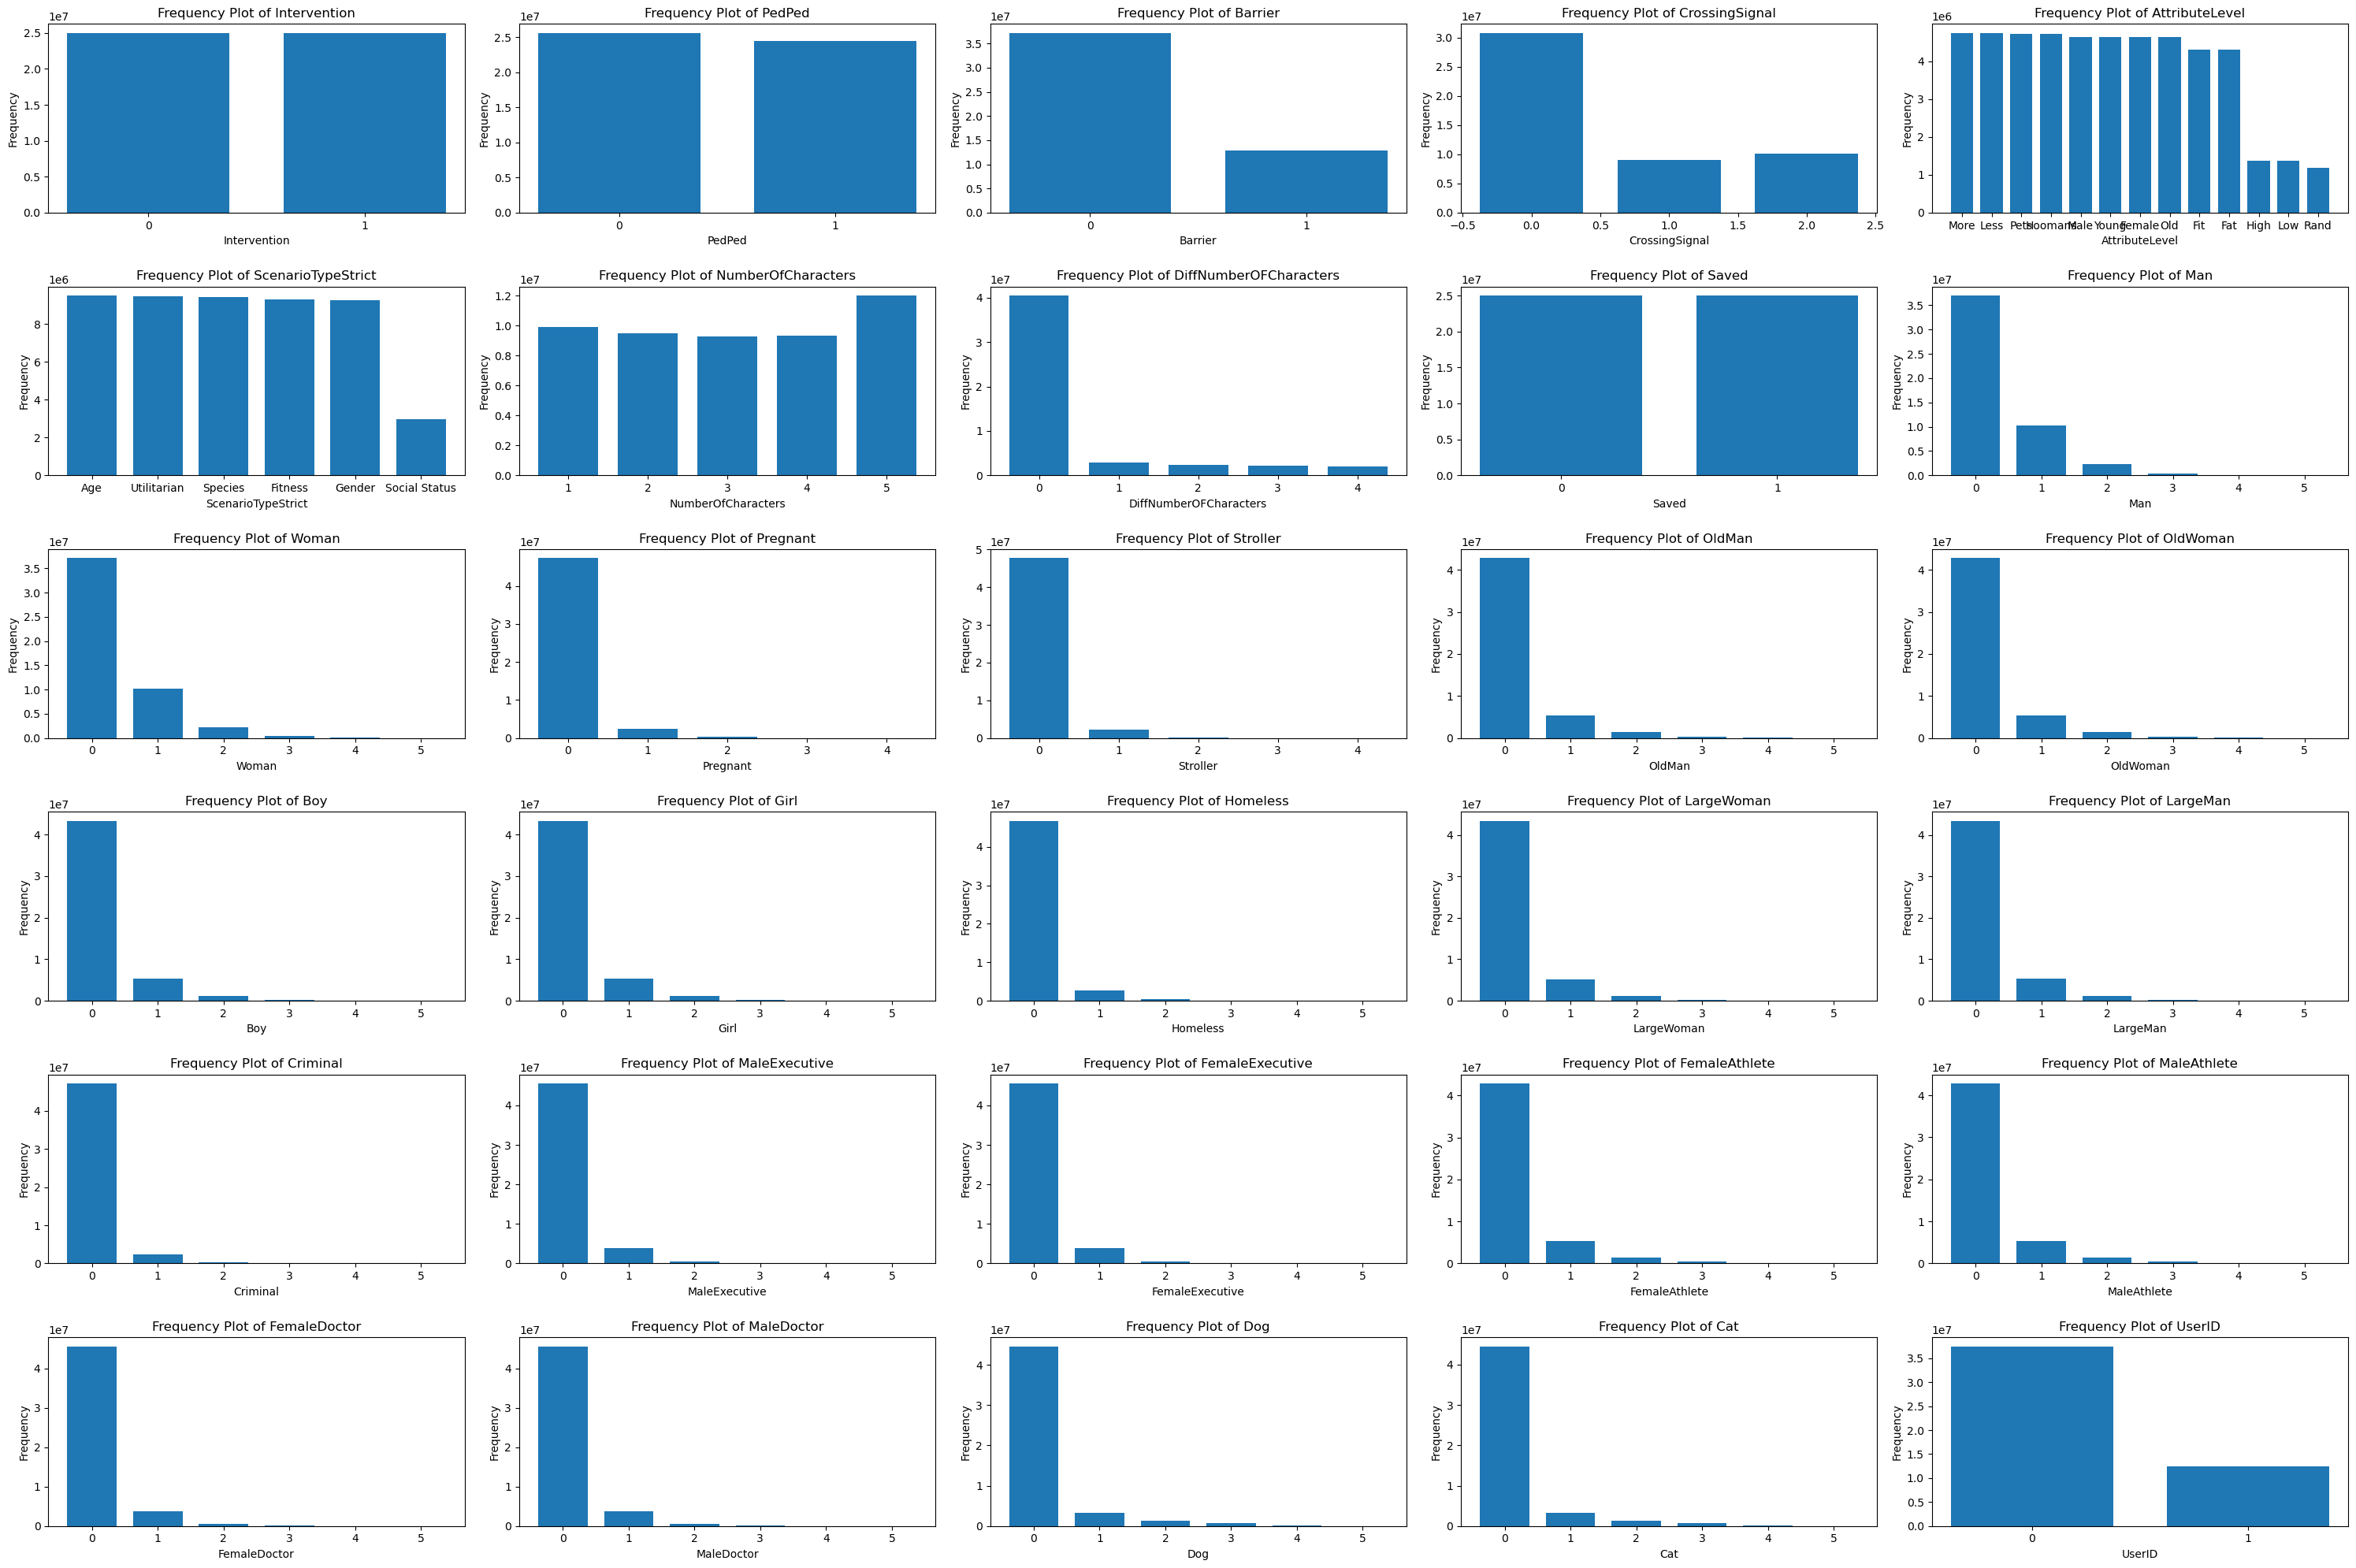

In [53]:
import pandas as pd
import matplotlib.pyplot as plt


# List of columns for which to plot the frequency plots
column_list = df75.columns.tolist()

# Set up the figure and subplots (adjust the number of rows/columns depending on the number of plots)
fig, axes = plt.subplots(6, 5, figsize=(30, 20))  # 2 rows, 3 columns, adjust as needed
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through the columns and create subplots
for i, column in enumerate(column_list):
    # Count the occurrences of each category
    category_counts = df75[column].value_counts()

    # Create a bar plot in the corresponding subplot axis
    axes[i].bar(category_counts.index, category_counts.values, width=0.75)

    # Add labels and title for each subplot
    axes[i].set_xlabel(str(column))
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f"Frequency Plot of {column}")

    # If the plot has only 2 categories, adjust the x-ticks to show 0 and 1
    if len(category_counts.index) == 2:
        axes[i].set_xticks([0, 1])

# Automatically adjust the layout for better spacing
plt.tight_layout()

# Show the entire figure with all subplots
plt.show()


In [28]:
# saving the new 75/25 dataset to a csv file
df75.to_csv('sub_dataset_75.csv', index=False)

### 50/50

In [ ]:
# Distribution of 
# 0 = 2.500.000
# 1 = 2.500.000
# to get a total dataset of 5.000.000

In [55]:
# extracting 2.500.000 rows with ResponseID = 0 from the original dataset

df_original = pd.read_csv('sub_dataset.csv', dtype=dtype)

In [56]:
df_original.shape

(5000000, 31)

In [57]:
# making subset of 2.5M of class 0, using the make_subset function from above
df50_sub_0 = make_subset('sub_dataset.csv', 2500000, 0, dtype)

Expected nr of rows in output df: 2500000
Processing chunk 1
Finished processing chunk 1
Processing chunk 2
Finished processing chunk 2
Processing chunk 3
Finished processing chunk 3
Processing chunk 4
Finished processing chunk 4
Processing chunk 5
Finished processing chunk 5
Processing chunk 6
Finished processing chunk 6
Processing chunk 7
Finished processing chunk 7
Processing chunk 8
Finished processing chunk 8
Processing chunk 9
Finished processing chunk 9
Processing chunk 10
Finished processing chunk 10
All chunks have been processed and combined.
(2500000, 31)
True


In [85]:
df50_sub_1 = pd.read_csv('llm_dataset.csv', dtype=dtype)

In [86]:
df50_sub_1.shape

(293568, 31)

In [87]:
df50_sub_1.columns

Index(['ResponseID', 'UserID', 'Intervention', 'PedPed', 'Barrier',
       'CrossingSignal', 'AttributeLevel', 'ScenarioTypeStrict',
       'NumberOfCharacters', 'DiffNumberOFCharacters', 'Saved', 'Man', 'Woman',
       'Pregnant', 'Stroller', 'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless',
       'LargeWoman', 'LargeMan', 'Criminal', 'MaleExecutive',
       'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor',
       'MaleDoctor', 'Dog', 'Cat'],
      dtype='object')

In [88]:
df50_sub_1['ScenarioTypeStrict'].value_counts()

ScenarioTypeStrict
Age              52868
Species          51230
Utilitarian      49456
Fitness          48690
Gender           47756
Social Status    43568
Name: count, dtype: int64

In [64]:
# combining the two subsets using the create_total_subset function from above
df50_before_oversampling = create_total_subset(df50_sub_0, df50_sub_1, dtype)

print(df50_before_oversampling.shape)
print(df50_before_oversampling['UserID'].value_counts())

(2793568, 31)
UserID
0    2500000
1     293568
Name: count, dtype: int64


In [ ]:
# Oversampling with RandomOverSampler

In [65]:
X_50 = df50_before_oversampling.drop(['UserID', 'ResponseID'], axis=1)      # drop ResponseID as well cause no need to oversample on this + not used in the modelling anyway
y_50 = df50_before_oversampling['UserID']

In [66]:
print(X_50.shape)
print(y_50.shape)

(2793568, 29)
(2793568,)


In [67]:
y_50.value_counts()

UserID
0    2500000
1     293568
Name: count, dtype: int64

In [68]:
# Apply Random Oversampling
# Use this technique to ensure that the distribution in terms of means and standard deviations stays similar to the original dataset
sampling_strategy = {0: 2500000, 1: 2500000}
random_oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

In [69]:
# Fit resampler
X_50_resampled, y_50_resampled = random_oversampler.fit_resample(X_50, y_50)

In [70]:
y_50_resampled.value_counts()

UserID
0    2500000
1    2500000
Name: count, dtype: int64

In [71]:
df50 = pd.concat([X_50_resampled, y_50_resampled], axis=1)
print(df50.shape)

(5000000, 30)


In [72]:
# comparing the descriptive statistics of the original dataset and the resampled dataset, on the UserID = 1 class (so on the LLM's, as this is the class that is oversampled)

pd.set_option('display.max_columns', None)                  # Show all columns
pd.set_option('display.float_format', '{:.4f}'.format)      # Show 4 decimals

# Original dataset
df_original[df_original['UserID'] == 1].describe()

,UserID,Intervention,PedPed,Barrier,CrossingSignal,NumberOfCharacters,DiffNumberOFCharacters,Saved,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat
count,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000
mean,1.0000,0.5000,0.5096,0.2452,0.5686,3.0181,0.2933,0.5000,0.3185,0.3110,0.0768,0.0425,0.1687,0.1664,0.1742,0.1687,0.1001,0.1511,0.1574,0.1005,0.1122,0.1121,0.1552,0.1603,0.1123,0.1118,0.1570,0.1611
std,0.0000,0.5000,0.4999,0.4302,0.7888,1.4110,0.7554,0.5000,0.5874,0.5809,0.3036,0.2142,0.4910,0.4867,0.4984,0.4871,0.3758,0.4605,0.4730,0.3816,0.3674,0.3651,0.4669,0.4741,0.3662,0.3653,0.5503,0.5588
min,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,1.0000,0.5000,1.0000,0.0000,0.0000,3.0000,0.0000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,1.0000,1.0000,1.0000,0.0000,1.0000,4.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,1.0000,1.0000,1.0000,1.0000,2.0000,5.0000,4.0000,1.0000,5.0000,5.0000,4.0000,3.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,4.0000,4.0000,5.0000,5.0000,4.0000,4.0000,5.0000,5.0000


In [73]:
# Oversampled dataset
df50[df50['UserID'] == 1].describe()

,Intervention,PedPed,Barrier,CrossingSignal,NumberOfCharacters,DiffNumberOFCharacters,Saved,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,UserID
count,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000,2500000.0000
mean,0.4999,0.5099,0.2447,0.5669,3.0140,0.2937,0.5002,0.3180,0.3107,0.0777,0.0424,0.1668,0.1669,0.1709,0.1660,0.1003,0.1526,0.1587,0.1001,0.1121,0.1116,0.1585,0.1607,0.1119,0.1107,0.1570,0.1603,1.0000
std,0.5000,0.4999,0.4299,0.7880,1.4129,0.7540,0.5000,0.5865,0.5808,0.3052,0.2151,0.4891,0.4894,0.4946,0.4831,0.3772,0.4635,0.4755,0.3797,0.3665,0.3645,0.4722,0.4760,0.3660,0.3640,0.5497,0.5582,0.0000
min,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
25%,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
50%,0.0000,1.0000,0.0000,0.0000,3.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
75%,1.0000,1.0000,0.0000,1.0000,4.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
max,1.0000,1.0000,1.0000,2.0000,5.0000,4.0000,1.0000,5.0000,5.0000,4.0000,4.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,4.0000,5.0000,5.0000,4.0000,4.0000,5.0000,5.0000,1.0000


In [ ]:
# after comparing, the descriptives statistics are very similar

In [ ]:
# want to also visually compare the distribution, so make some plots to compare with the plots of the EDA in the original dataset

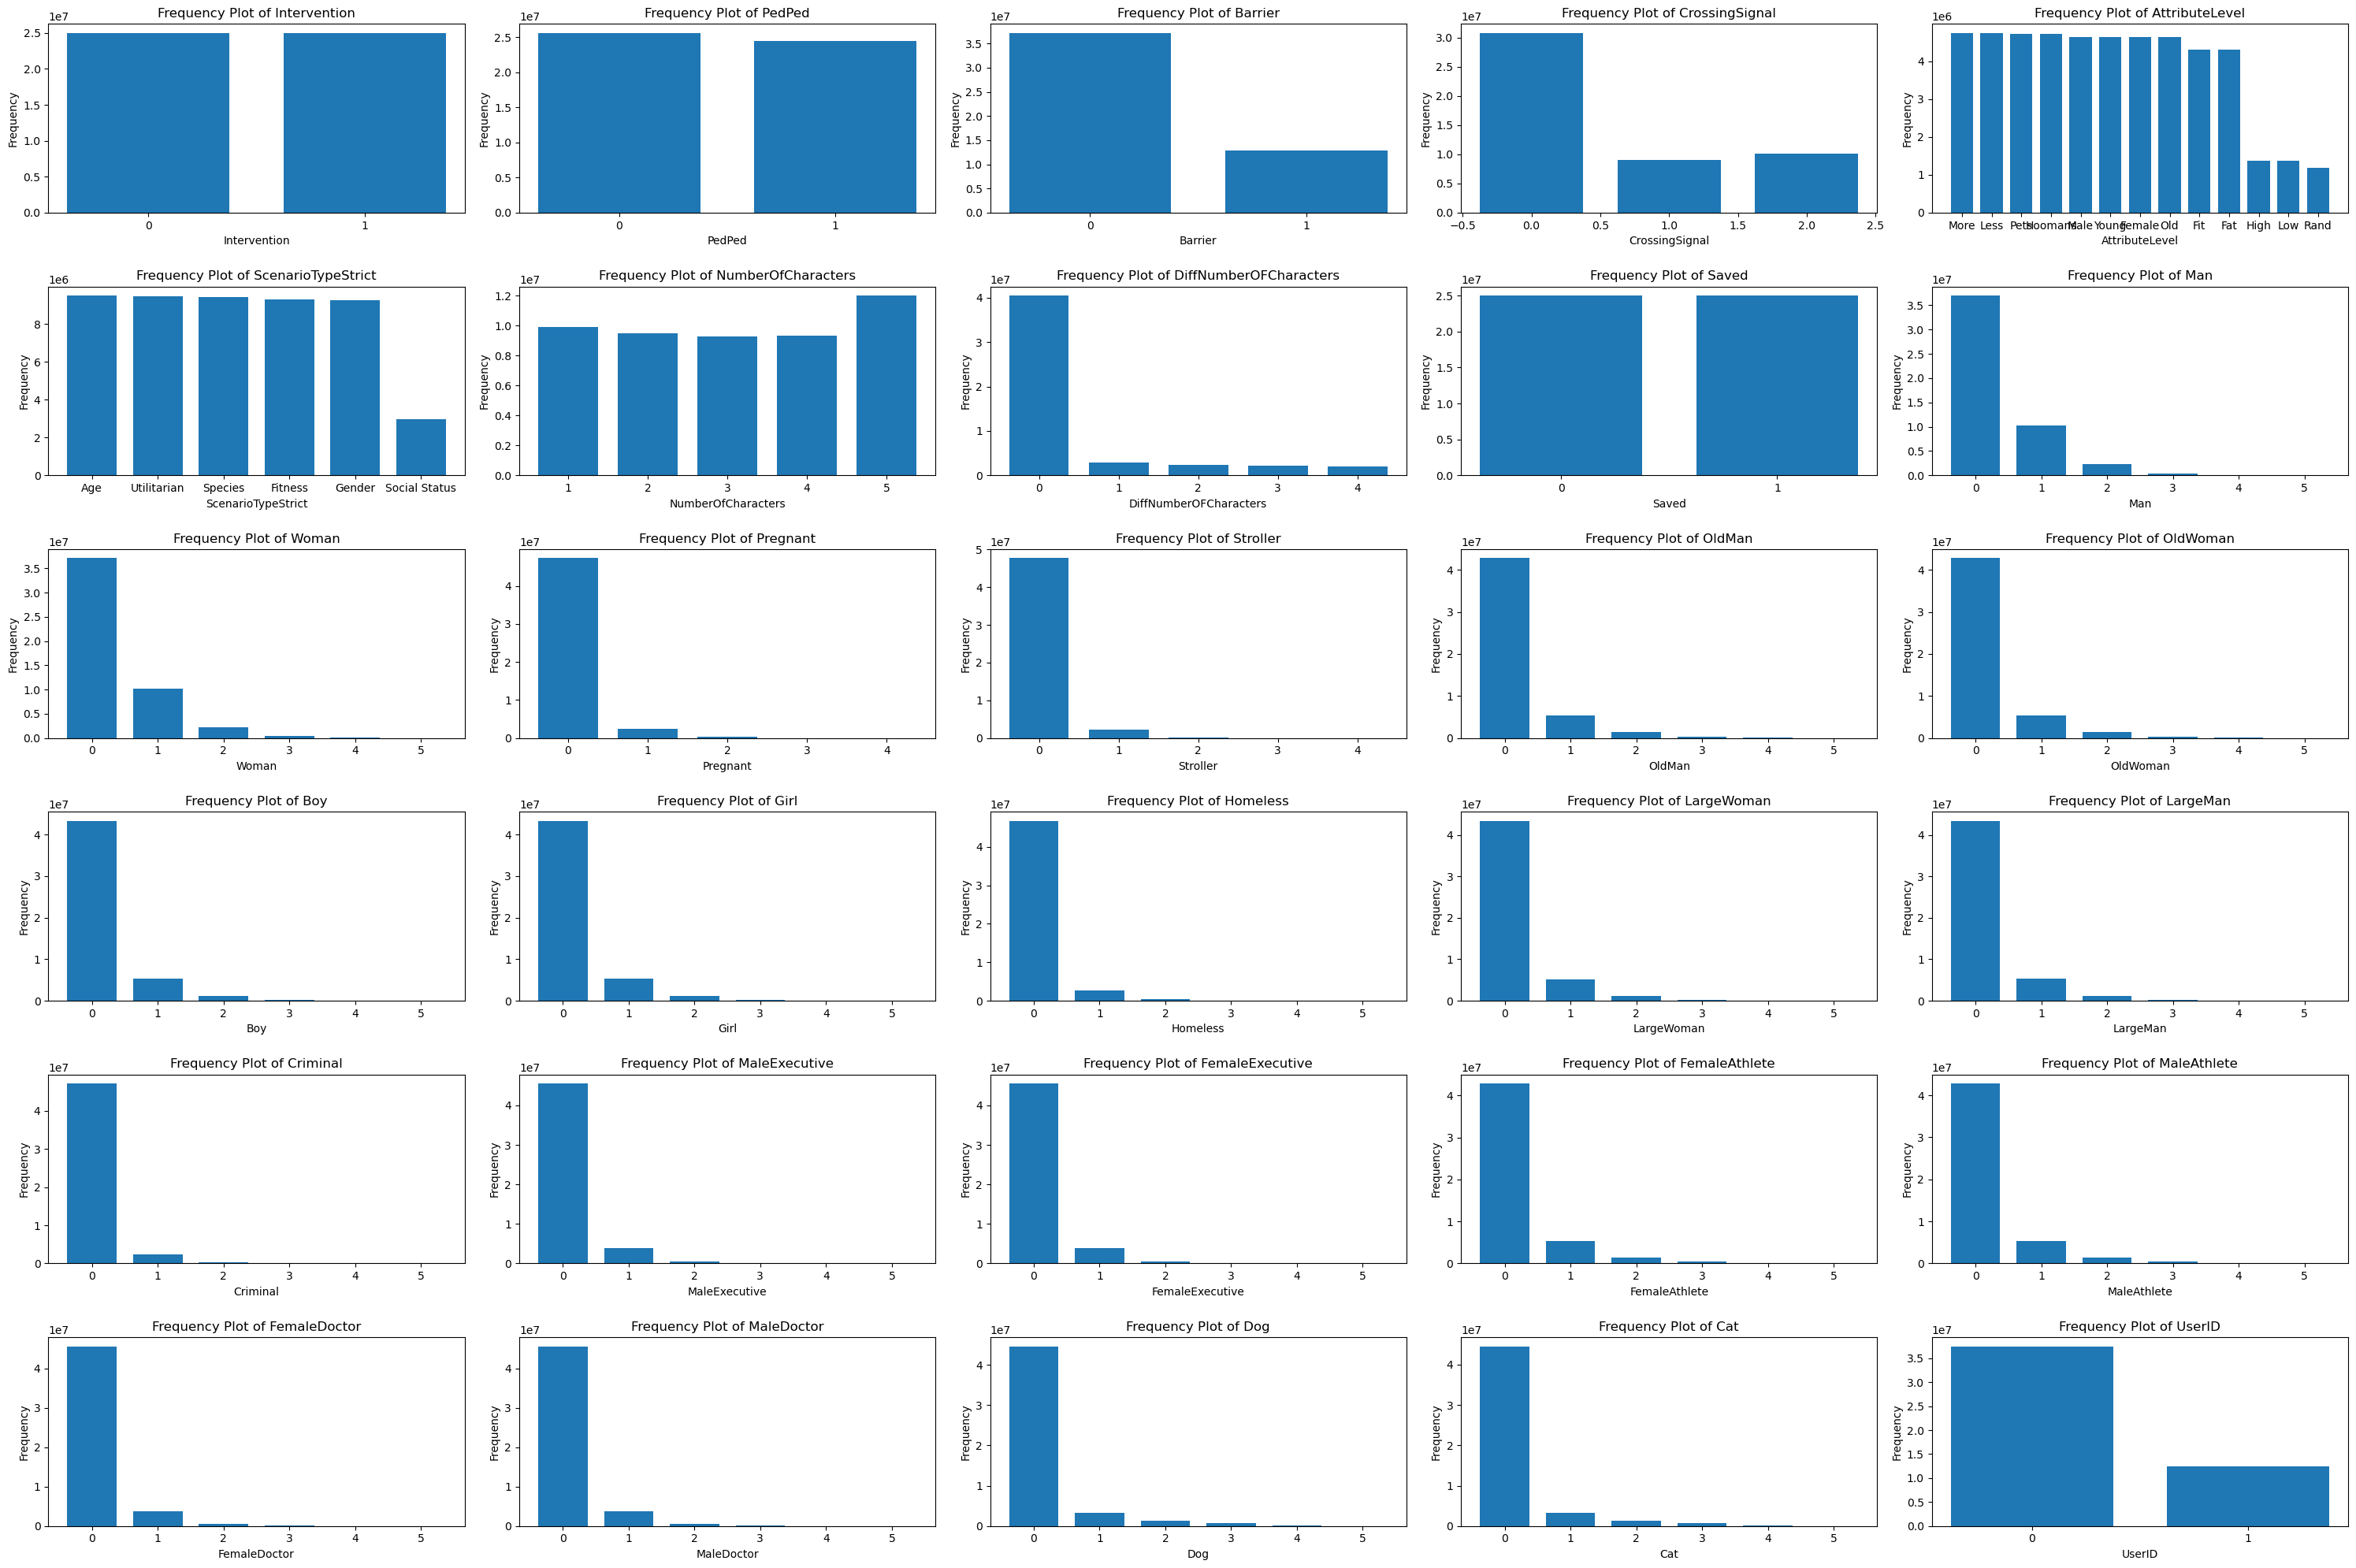

In [74]:
import pandas as pd
import matplotlib.pyplot as plt


# List of columns for which to plot the frequency plots
column_list = df75.columns.tolist()

# Set up the figure and subplots (adjust the number of rows/columns depending on the number of plots)
fig, axes = plt.subplots(6, 5, figsize=(30, 20))  # 2 rows, 3 columns, adjust as needed
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through the columns and create subplots
for i, column in enumerate(column_list):
    # Count the occurrences of each category
    category_counts = df75[column].value_counts()

    # Create a bar plot in the corresponding subplot axis
    axes[i].bar(category_counts.index, category_counts.values, width=0.75)

    # Add labels and title for each subplot
    axes[i].set_xlabel(str(column))
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f"Frequency Plot of {column}")

    # If the plot has only 2 categories, adjust the x-ticks to show 0 and 1
    if len(category_counts.index) == 2:
        axes[i].set_xticks([0, 1])

# Automatically adjust the layout for better spacing
plt.tight_layout()

# Show the entire figure with all subplots
plt.show()


In [ ]:
# saving the new 75/25 dataset to a csv file
df50.to_csv('sub_dataset_50.csv', index=False)

In [80]:
len(df_original['AttributeLevel'].value_counts())

13

In [82]:
df_original['AttributeLevel'].value_counts()

AttributeLevel
Less       490618
More       490618
Hoomans    482224
Pets       482224
Female     481672
Male       481672
Old        467836
Young      467836
Fat        435182
Fit        435182
Rand       155090
High        64923
Low         64923
Name: count, dtype: int64

In [81]:
df_llm = pd.read_csv('llm_dataset.csv')

In [79]:
len(df_llm['AttributeLevel'].value_counts())

12